# Part 4 - Dynamic Hedging

So far we looked at option valuation, model calibration and static replication of payoff. Lets look at dynamic hedging of option using Black-Scholes model.

Black-Scholes introduced the notion of dynamic delta hedging - by executing delta hedges instantaneously, we ensure that our portfolio is delta neutral, and consequently hedged the exposure of our call position using the underlying stock and the risk-free bond. 

The hedged portfolio is $V_t=\phi_tS_t+\psi_tB_t$, where 
\begin{equation*}
\phi_t=\Delta_t=\frac{\partial C}{\partial S}=\Phi\left(\frac{\log\frac{S}{K}+\left(r+\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}\right)
\end{equation*}

and

\begin{equation*}
\psi_tB_t=-Ke^{-rT}\Phi\left(\frac{\log\frac{S}{K}+\left(r-\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}\right)
\end{equation*}

Let us start by defining these stock and bond holding functions:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm 
from matplotlib.ticker import PercentFormatter

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Parameter assumption
S = 100
sigma = 0.2
r = 0.05
T = 1/12
K = 100

In [3]:
#Black Scholes call option pricing formula
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

In [4]:
price = BlackScholesCall(S, K, r, sigma, T)
print(f'Price of the call option is : {price}')

Price of the call option is : 2.5120670860398846


In [5]:
#Function to simulate the stock price using Black Scholes model
def simulate_Brownian_Motion(paths, steps, T):
    deltaT = T/steps
    t = np.linspace(0, T, steps+1)
    X = np.c_[np.zeros((paths, 1)),
              np.random.randn(paths, steps)]
    return t, np.cumsum(np.sqrt(deltaT) * X, axis=1)

Suppose we sell the at the money call option and we hedge N times during the life of the call option. Lets work out the hedging error of the dynamic delta hedging strategy.

We will use 5000 paths in our simulation and consider N = 21 and N = 84

> N = 21

In [6]:
paths = 50000
steps = 21
maturity = 1/12

T, W_T = simulate_Brownian_Motion(paths, steps, maturity)

r = 0.05
S0 = 100.0
K = 100.0
sigma = 0.2
dt = maturity / steps
blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T[0]) # Just take first path to plot

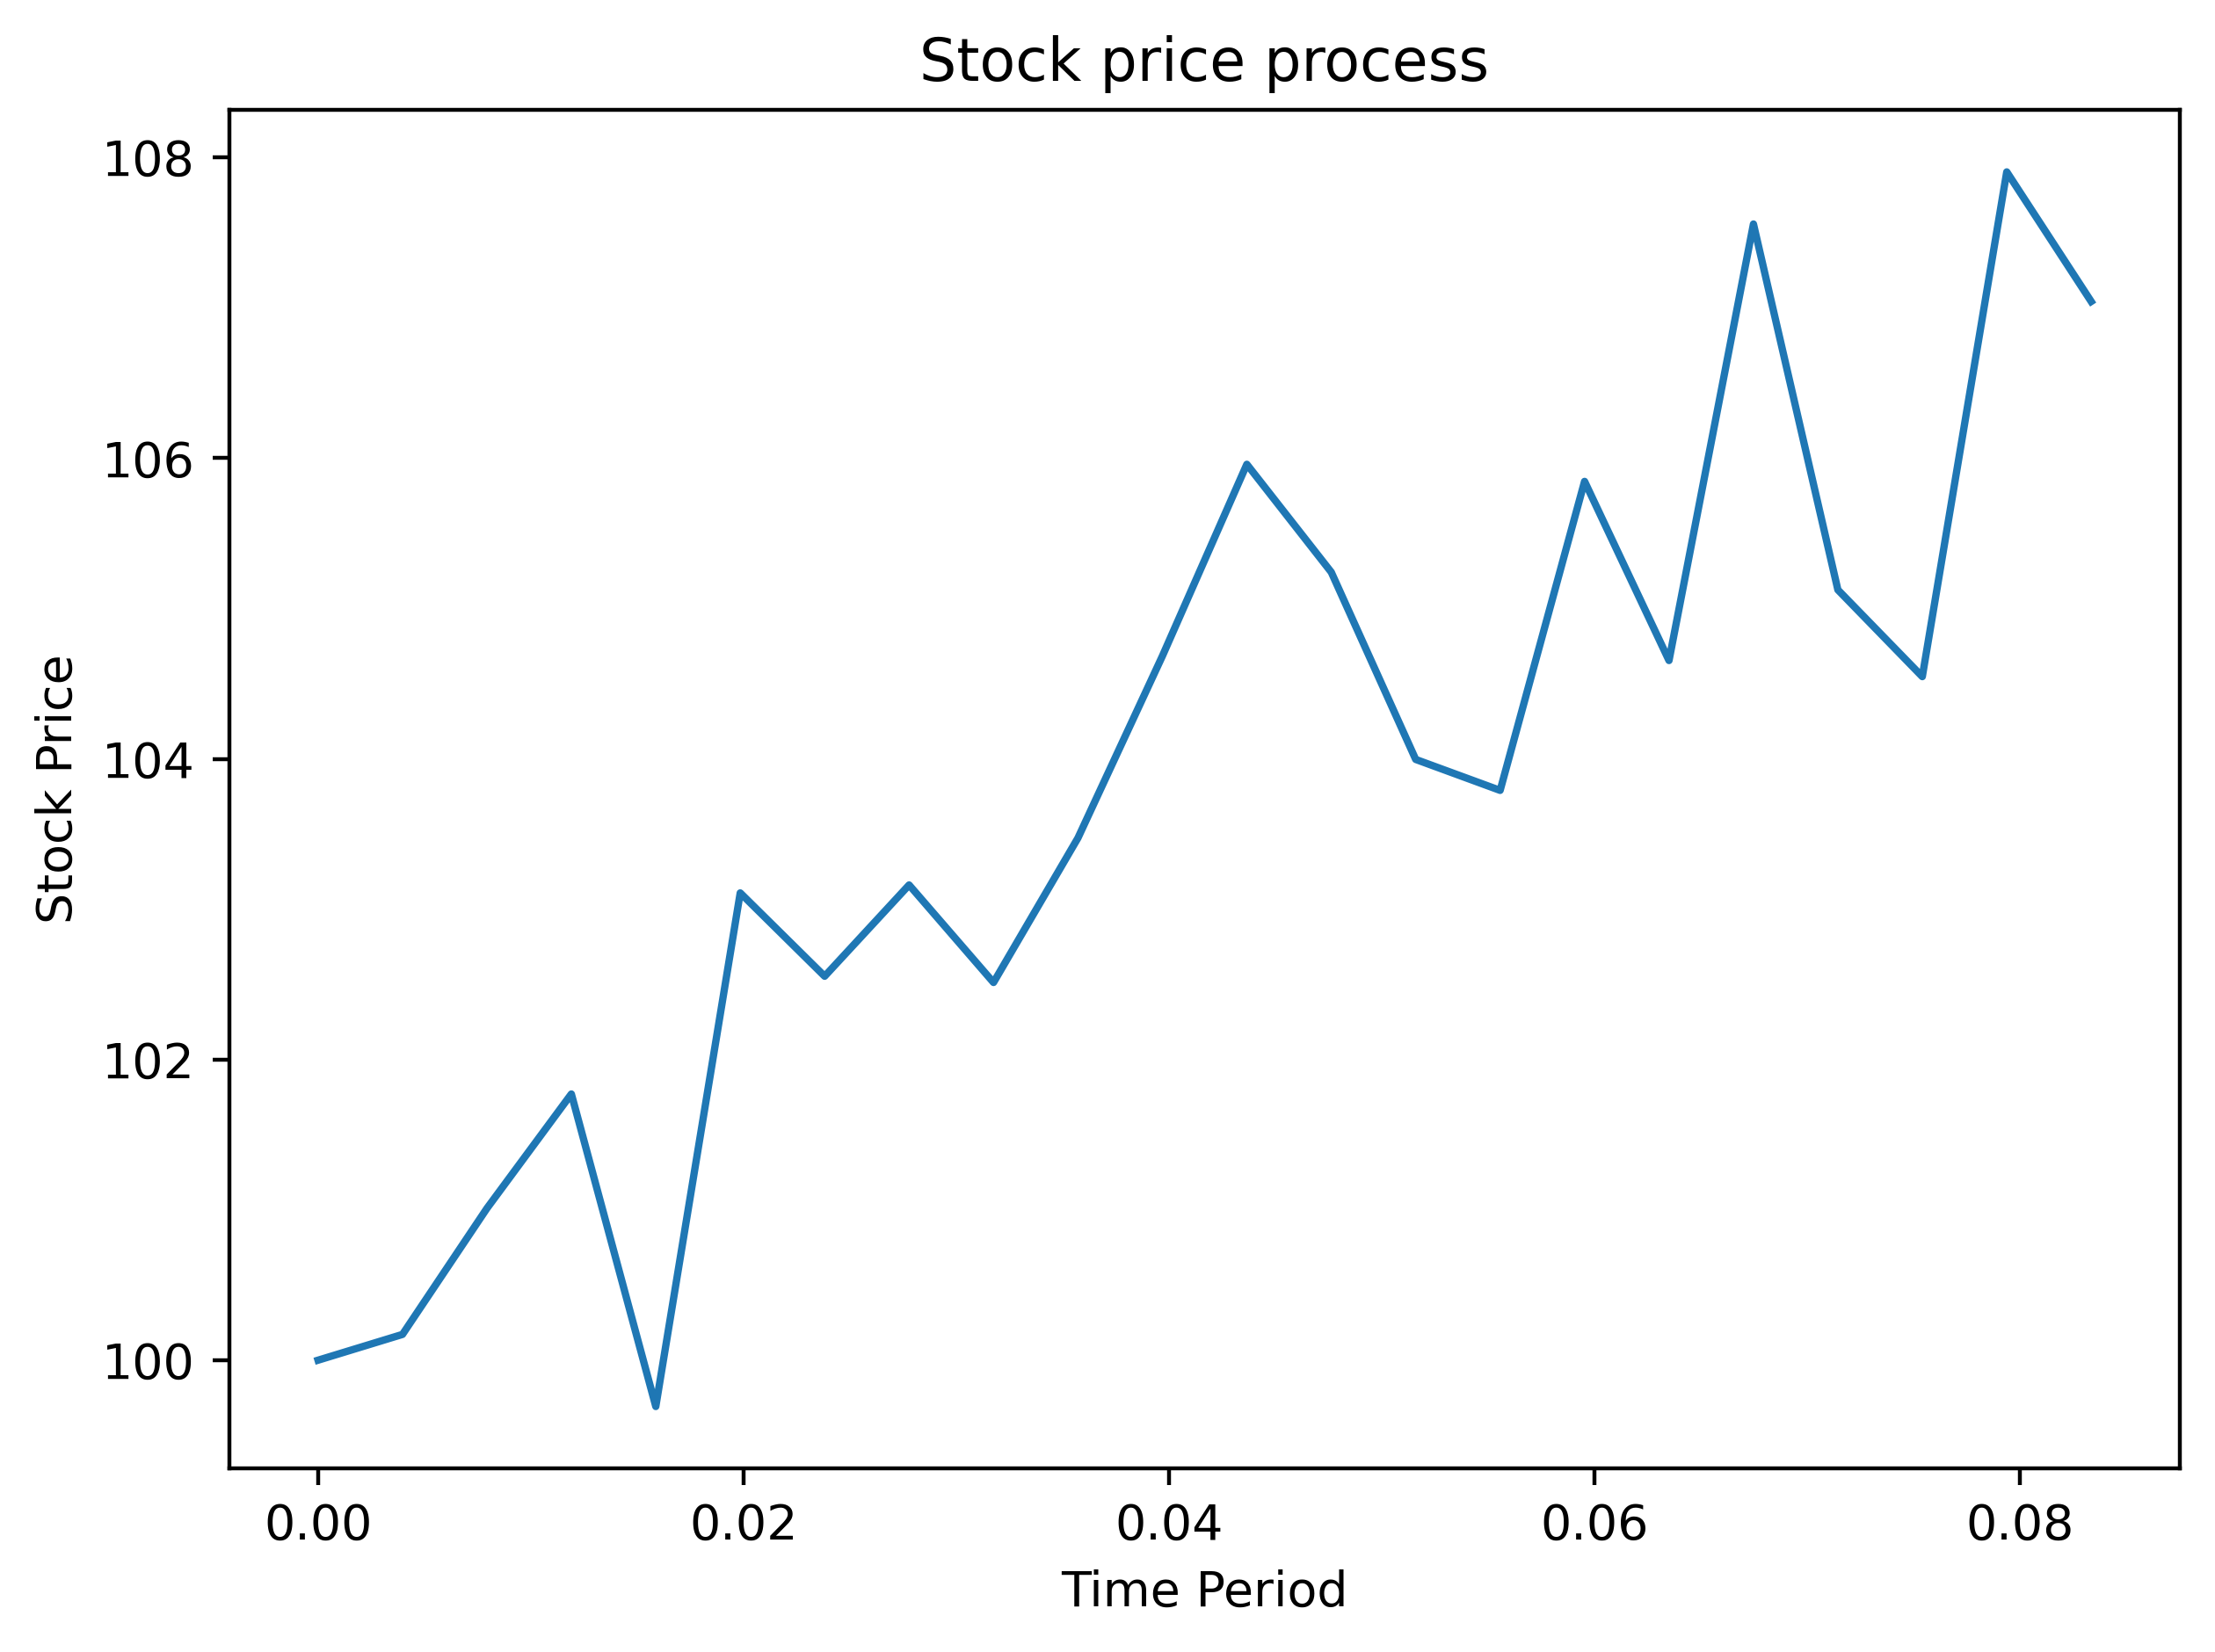

In [7]:
plt.figure(tight_layout=True, dpi=400)
plt.plot(T, blackscholespath)
plt.title('Stock price process')
plt.ylabel('Stock Price')
plt.xlabel('Time Period')
plt.show()

In [8]:
#Amount of stock we need to hedge
def phi(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1)

#Amount of bond we need to short
def psi_Bt(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return -K*np.exp(-r*T)*norm.cdf(d2)

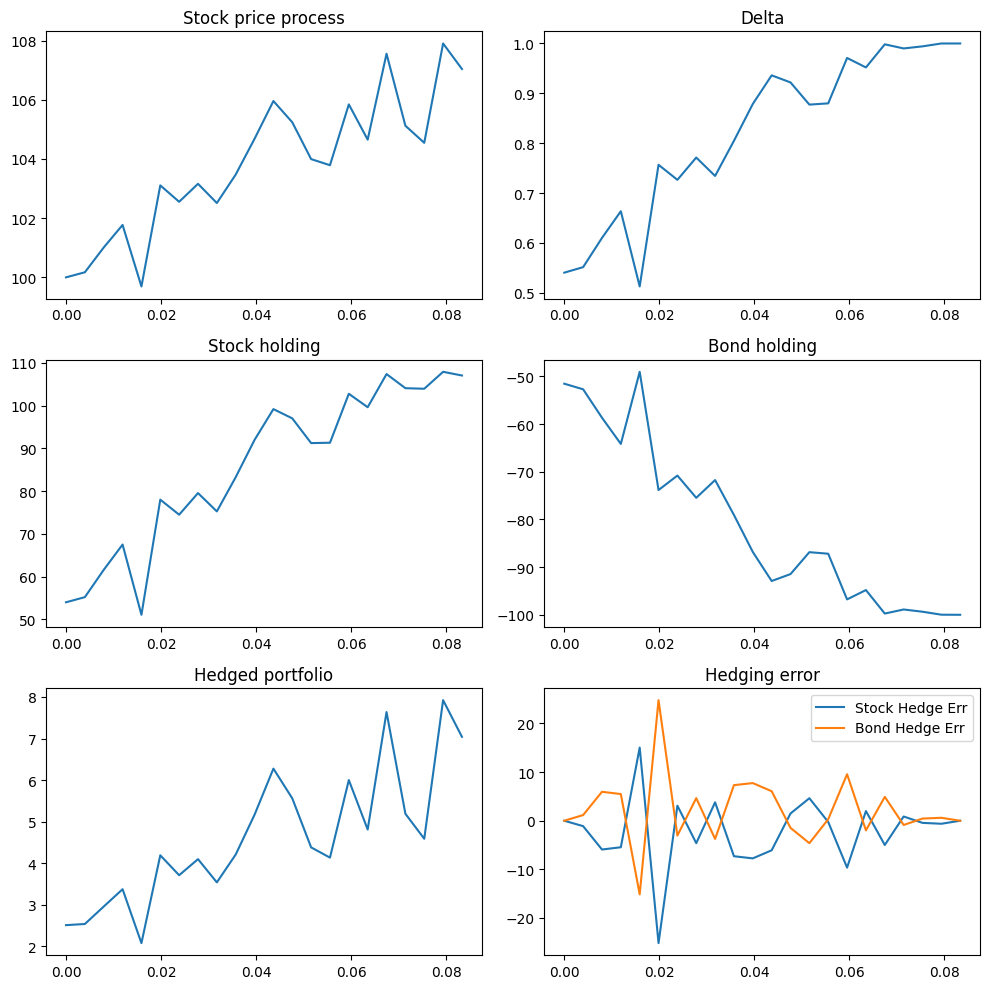

In [9]:
#Lets plot stock and bond holding for a particular path and also plot the hedging error.
deltas = []
stockhedge_errors = []
bondhedge_errors = []
hedged_portfolios = []
stock_holdings = []
bond_holdings = []
for t, S_t in zip(T, blackscholespath):
    stock_pos = phi(S_t, K, r, sigma, maturity-t)*S_t
    bond_pos = psi_Bt(S_t, K, r, sigma, maturity-t)
    V_t = stock_pos + bond_pos
    stock_holdings.append(stock_pos)
    bond_holdings.append(bond_pos)
    hedged_portfolios.append(V_t)
    deltas.append(phi(S_t, K, r, sigma, maturity-t))
    if t == 0.0:
        stockhedge_errors.append(0)
        bondhedge_errors.append(0)
    else:
        stockhedge_errors.append(prev_phi*S_t - stock_pos)
        bondhedge_errors.append(prev_bond_pos*np.exp(r*dt) - bond_pos)

    prev_phi = phi(S_t, K, r, sigma, maturity-t)
    prev_bond_pos = bond_pos

plt.figure(tight_layout=True, figsize=(10, 10))
plt.subplot(321)
plt.plot(T, blackscholespath)
plt.title('Stock price process')
plt.subplot(322)
plt.plot(T, deltas)
plt.title('Delta')
plt.subplot(323)
plt.plot(T, stock_holdings)
plt.title('Stock holding')
plt.subplot(324)
plt.plot(T, bond_holdings)
plt.title('Bond holding')
plt.subplot(325)
plt.plot(T, hedged_portfolios)
plt.title('Hedged portfolio')
plt.subplot(326)
plt.plot(T, stockhedge_errors, label='Stock Hedge Err')
plt.plot(T, bondhedge_errors, label='Bond Hedge Err')
plt.legend()
plt.title('Hedging error')
plt.show()

Hedging error for a particular path is the difference between the amount of stock, bond we have and what we currently need based on the price movement.  

In [10]:
#Calculate hedging error for N = 21

#Calculate all the possible price paths
blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T)

In [11]:
V_t = []
for i in range(steps+1):
    t = T[i]
    S_t = blackscholespath[:,i]
    stock_pos = phi(S_t, K, r, sigma, maturity-t)*S_t
    bond_pos = psi_Bt(S_t, K, r, sigma, maturity-t)
    V_t = stock_pos + bond_pos

    if t == 0.0:
        hedging_error = np.zeros(paths)
    else:
        stockhedge_errors = (prev_phi*S_t - stock_pos)
        bondhedge_errors = (prev_bond_pos*np.exp(r*dt) - bond_pos)
        hedging_error += (stockhedge_errors + bondhedge_errors)
    V_t
    prev_phi = phi(S_t, K, r, sigma, maturity-t)
    prev_bond_pos = bond_pos 

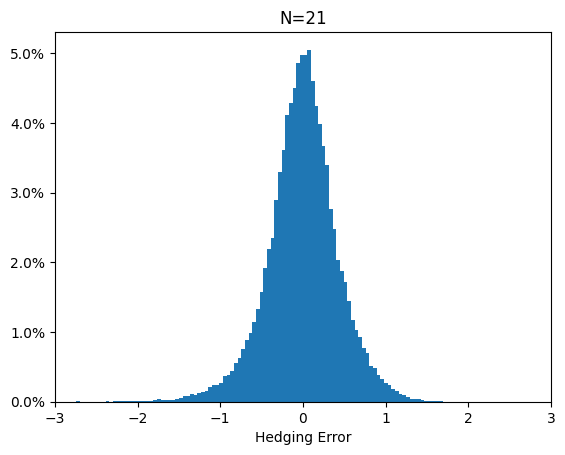

In [12]:
#distribution of the hedging error of 50000 paths
W = np.ones(len(hedging_error))/len(hedging_error)
plt.hist(hedging_error,weights=W,bins=100)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Hedging Error')
plt.title('N=21')
plt.xlim(-3,3)
plt.show()

In [13]:
#Statistical Summary
meanhedge21 = hedging_error.mean()
stdhedge21 = hedging_error.std()
stdhedge_PercentageOfPremium21 = stdhedge21/price

> N = 84

In [14]:
paths = 5000
steps = 84
maturity = 1/12

T, W_T = simulate_Brownian_Motion(paths, steps, maturity)

r = 0.05
S0 = 100.0
K = 100.0
sigma = 0.2
dt = maturity / steps
blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T[0]) # Just take first path to plot

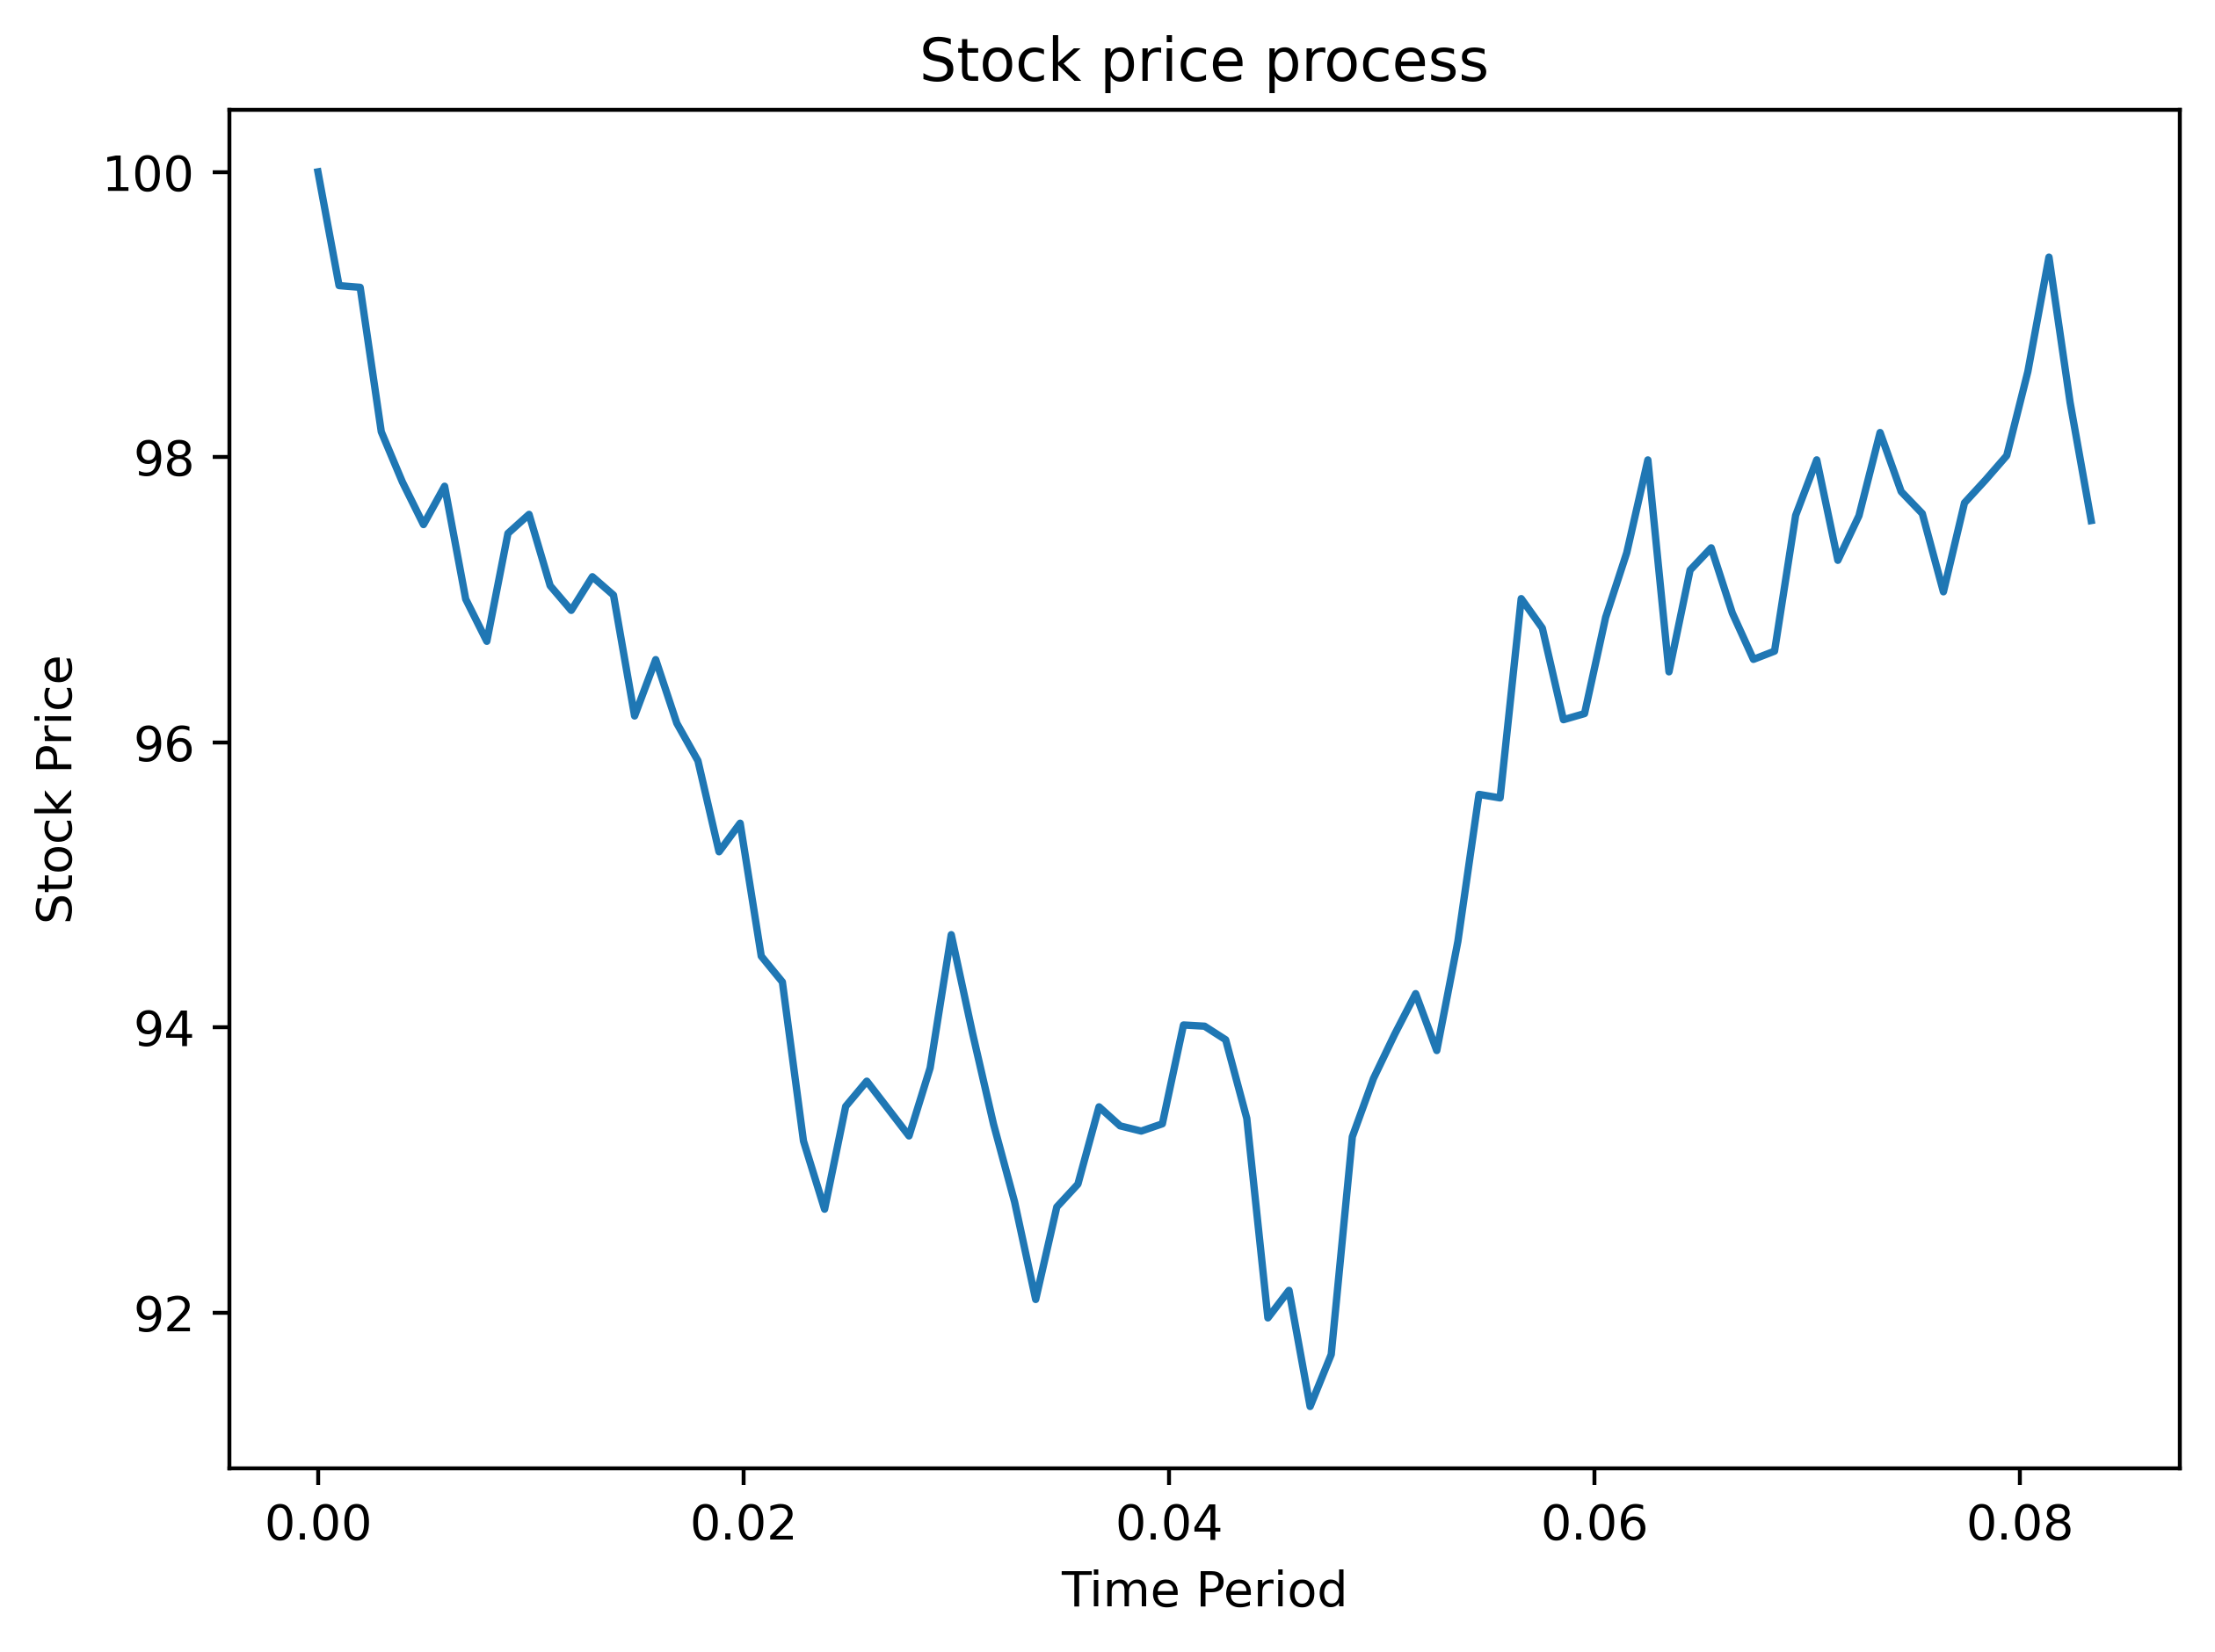

In [15]:
plt.figure(tight_layout=True, dpi=400)
plt.plot(T, blackscholespath)
plt.title('Stock price process')
plt.ylabel('Stock Price')
plt.xlabel('Time Period')
plt.show()

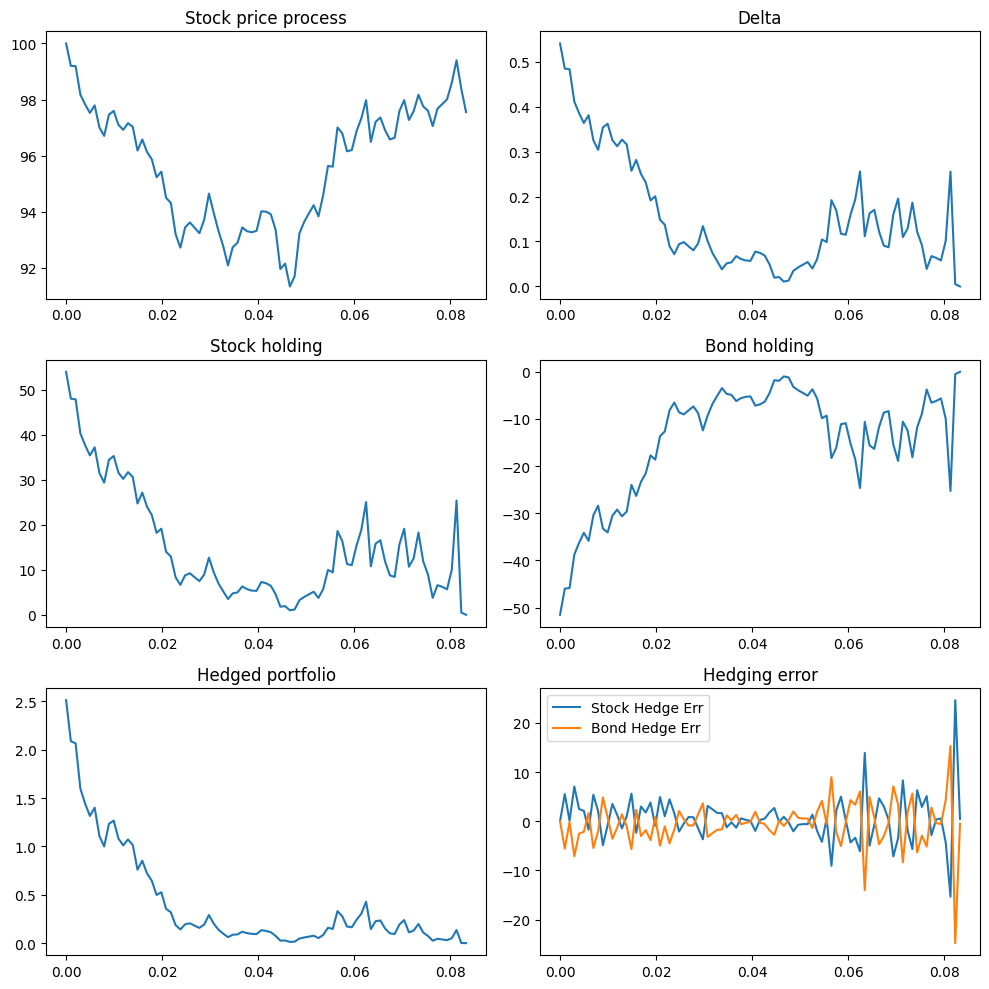

In [16]:
#Lets plot stock and bond holding for a particular path and also plot the hedging error.
deltas = []
stockhedge_errors = []
bondhedge_errors = []
hedged_portfolios = []
stock_holdings = []
bond_holdings = []
for t, S_t in zip(T, blackscholespath):
    stock_pos = phi(S_t, K, r, sigma, maturity-t)*S_t
    bond_pos = psi_Bt(S_t, K, r, sigma, maturity-t)
    V_t = stock_pos + bond_pos
    stock_holdings.append(stock_pos)
    bond_holdings.append(bond_pos)
    hedged_portfolios.append(V_t)
    deltas.append(phi(S_t, K, r, sigma, maturity-t))
    if t == 0.0:
        stockhedge_errors.append(0)
        bondhedge_errors.append(0)
    else:
        stockhedge_errors.append(prev_phi*S_t - stock_pos)
        bondhedge_errors.append(prev_bond_pos*np.exp(r*dt) - bond_pos)

    prev_phi = phi(S_t, K, r, sigma, maturity-t)
    prev_bond_pos = bond_pos

plt.figure(tight_layout=True, figsize=(10, 10))
plt.subplot(321)
plt.plot(T, blackscholespath)
plt.title('Stock price process')
plt.subplot(322)
plt.plot(T, deltas)
plt.title('Delta')
plt.subplot(323)
plt.plot(T, stock_holdings)
plt.title('Stock holding')
plt.subplot(324)
plt.plot(T, bond_holdings)
plt.title('Bond holding')
plt.subplot(325)
plt.plot(T, hedged_portfolios)
plt.title('Hedged portfolio')
plt.subplot(326)
plt.plot(T, stockhedge_errors, label='Stock Hedge Err')
plt.plot(T, bondhedge_errors, label='Bond Hedge Err')
plt.legend()
plt.title('Hedging error')
plt.show()

In [17]:
#Calculate hedging error for N = 84

#Calculate all the possible price paths
blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T)

In [18]:
for i in range(steps+1):
    t = T[i]
    S_t = blackscholespath[:,i]
    stock_pos = phi(S_t, K, r, sigma, maturity-t)*S_t
    bond_pos = psi_Bt(S_t, K, r, sigma, maturity-t)
    V_t = stock_pos + bond_pos

    if t == 0.0:
        hedging_error = np.zeros(paths)
    else:
        stockhedge_errors = (prev_phi*S_t - stock_pos)
        bondhedge_errors = (prev_bond_pos*np.exp(r*dt) - bond_pos)
        hedging_error += (stockhedge_errors + bondhedge_errors)

    prev_phi = phi(S_t, K, r, sigma, maturity-t)
    prev_bond_pos = bond_pos 

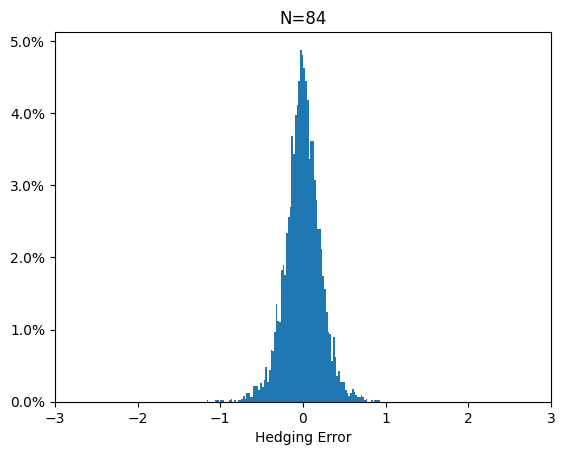

In [19]:
#distribution of the hedging error of 50000 paths
W = np.ones(len(hedging_error))/len(hedging_error)
plt.hist(hedging_error,weights=W,bins=100)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Hedging Error')
plt.title('N=84')
plt.xlim(-3,3)
plt.show()

In [20]:
#Statistical Summary
meanhedge84 = hedging_error.mean()
stdhedge84 = hedging_error.std()
stdhedge_PercentageOfPremium84 = stdhedge84/price

Summary - From results we can conclude that hedging more frequently reduces the std of error. The std as a fraction of the option premium is around 16% for N = 21 and 8% for N = 84; hedging four times as frequently roughly halves the std of the replication error.

Had we continuously hedged our portfolio, the error would have been perfect zero.

In [21]:
Results = pd.DataFrame({'Number of Trades':[21,84],
                       'Mean Error':np.round([meanhedge21,meanhedge84],3),
                       'Std of Error':np.round([stdhedge21,stdhedge84],3),
                       'Std of Error as % of Premium':[stdhedge_PercentageOfPremium21*100,stdhedge_PercentageOfPremium84*100]},
                      index=[1,2])
Results

,Number of Trades,Mean Error,Std of Error,Std of Error as % of Premium
1,21,-0.002,0.427,17.003134
2,84,-0.001,0.215,8.567699
